# 4.1 Data Reduction

In [1]:
import pyspark
from pyspark.sql.functions import col, count, isnan, when
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("PySpark in Jupyter") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 11:54:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/23 11:54:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/23 11:54:12 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/05/23 11:54:12 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [2]:
df = spark.read.csv('Dataset/df_new_4.csv', header=True, inferSchema=True)

In [3]:
# Identify string columns
string_columns = [field.name for field in df.schema.fields if str(field.dataType) == 'StringType']

# Step 1: Convert string columns to numerical using StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in string_columns]

# Apply StringIndexer to create indexed DataFrame
df_indexed = df
for indexer in indexers:
    df_indexed = indexer.transform(df_indexed)

# Step 2: Assemble features into a single vector column
indexed_columns = [column+"_index" if column in string_columns else column for column in df.columns if column != 'target_column']  # Exclude the target column
vector_assembler = VectorAssembler(inputCols=indexed_columns, outputCol="features")

# Step 3: Create a Random Forest classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="Dementia", numTrees=100)

# Step 4: Create a Pipeline to chain indexers and classifier
stages = indexers + [vector_assembler, rf]
pipeline = Pipeline(stages=stages)

# Step 5: Fit the pipeline to the data
model = pipeline.fit(df)

# Step 6: Extract feature importance
rf_model = model.stages[-1]
feature_importance = rf_model.featureImportances.toArray()

# Create a dictionary to store feature importance scores
feature_importance_dict = {indexed_columns[i]: feature_importance[i] for i in range(len(indexed_columns))}

# Sort feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display feature importance scores in a nice table format
print("{:<30} {:<20}".format("Feature", "Importance Score"))
print("-" * 50)
for feature, score in sorted_feature_importance:
    print("{:<30} {:<20}".format(feature, round(score, 4)))



Feature                        Importance Score    
--------------------------------------------------
Dementia                       0.5183              
Cognitive_Test_Scores          0.3353              
Depression_Status_index        0.0753              
APOE_ε4_index                  0.0477              
Smoking_Status_index           0.0161              
BodyTemperature                0.0015              
Weight                         0.0014              
Age                            0.0012              
Family_History_index           0.0009              
HeartRate                      0.0006              
AlcoholLevel                   0.0004              
Chronic_Health_Conditions_index 0.0003              
Education_Group_index          0.0002              
MRI_Delay                      0.0002              
Physical_Activity_index        0.0002              
Nutrition_Diet_index           0.0002              
Education_Level_index          0.0001              
Gender_index

In [4]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("GBTClassifierExample").getOrCreate()

# Example DataFrame
# Assuming df_indexed is your DataFrame and 'Dementia' is your label column

# Step 1: Identify categorical and numerical columns
categorical_columns = ["Education_Level", "Gender", "Family_History", "Smoking_Status", 
                       "APOE_ε4", "Physical_Activity", "Depression_Status", 
                       "Nutrition_Diet", "Sleep_Quality", "Chronic_Health_Conditions", "Education_Group"]
numerical_columns = [col for col in df_indexed.columns if col not in categorical_columns + ["Dementia"]]

# Step 2: Index and encode categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed") for column in categorical_columns]
encoders = [OneHotEncoder(inputCol=column+"_indexed", outputCol=column+"_encoded") for column in categorical_columns]

# Step 3: Assemble features into a single vector column
assembler = VectorAssembler(inputCols=[col+"_encoded" for col in categorical_columns] + numerical_columns, outputCol="features")

# Step 4: Create a Gradient-Boosted Tree classifier
xgb = GBTClassifier(featuresCol="features", labelCol="Dementia")

# Step 5: Create a Pipeline to chain indexers, encoders, assembler, and classifier
pipeline_xgb = Pipeline(stages=indexers + encoders + [assembler, xgb])

# Step 6: Fit the pipeline to the data
model_xgb = pipeline_xgb.fit(df_indexed)

# Step 7: Extract feature importance from the model
xgb_model = model_xgb.stages[-1]
feature_importance_xgb = xgb_model.featureImportances.toArray()

# Step 8: Display feature importance scores
print("{:<30} {:<20}".format("Feature", "Importance Score"))
print("-" * 50)
input_cols = [col+"_encoded" for col in categorical_columns] + numerical_columns
for feature, score in zip(input_cols, feature_importance_xgb):
    print("{:<30} {:<20}".format(feature, round(score, 4)))



Feature                        Importance Score    
--------------------------------------------------
Education_Level_encoded        0.0                 
Gender_encoded                 0.0                 
Family_History_encoded         0.0                 
Smoking_Status_encoded         0.0                 
APOE_ε4_encoded                0.0                 
Physical_Activity_encoded      0.0                 
Depression_Status_encoded      0.0                 
Nutrition_Diet_encoded         0.0                 
Sleep_Quality_encoded          0.0                 
Chronic_Health_Conditions_encoded 0.0                 
Education_Group_encoded        0.0                 
Diabetic                       0.0                 
AlcoholLevel                   0.0                 
HeartRate                      0.0                 
BodyTemperature                0.0                 
Weight                         0.0                 
MRI_Delay                      0.0                 
Age       

In [5]:
# Manually select the columns you want to keep
selected_columns_d = ['Gender', 'Chronic_Health_Conditions', 'Nutrition_Diet', 'Physical_Activity', 'Diabetic', 'Sleep_Quality']
selected_columns_wd = ['Gender', 'Chronic_Health_Conditions', 'Nutrition_Diet', 'Physical_Activity', 'Diabetic', 'Sleep_Quality','Dementia']

# Select the desired columns from the DataFrame
df_filtered_dementia = df.drop(*selected_columns_d)
df_filtered_wdementia = df.drop(*selected_columns_wd)

In [6]:
def spark_info(df):
    # Get the schema of the DataFrame
    schema = df.schema
    
    # Create a list to hold column information
    columns_info = []
    
    # Iterate through the schema to get column information
    for field in schema:
        column_name = field.name
        column_type = field.dataType.simpleString()
        
        # Count non-null values
        non_null_count = df_filtered_dementia.filter(col(column_name).isNotNull()).count()
        
        # Count null values
        null_count = df_filtered_dementia.filter(col(column_name).isNull() | isnan(col(column_name))).count()
        
        columns_info.append((column_name, column_type, non_null_count, null_count))
    
    # Display the DataFrame schema and summary
    total_rows = df_filtered_dementia.count()
    total_columns = len(schema)
    
    # Print the summary table
    print(f"DataFrame Summary:")
    print(f"{'Total Rows':<15}: {total_rows}")
    print(f"{'Total Columns':<15}: {total_columns}")
    print("\nDataFrame Schema:")
    print(f"{'Column':<25} {'Non-Null Count':<15} {'Null Count':<10} {'Dtype':<10}")
    print("-" * 60)
    for column_info in columns_info:
        print(f"{column_info[0]:<25} {column_info[2]:<15} {column_info[3]:<10} {column_info[1]:<10}")

# Call the function to describe the DataFrame
spark_info(df_filtered_dementia)

DataFrame Summary:
Total Rows     : 2271
Total Columns  : 14

DataFrame Schema:
Column                    Non-Null Count  Null Count Dtype     
------------------------------------------------------------
AlcoholLevel              2271            0          double    
HeartRate                 2271            0          double    
BodyTemperature           2271            0          double    
Weight                    2271            0          double    
MRI_Delay                 2271            0          double    
Age                       2271            0          double    
Education_Level           2271            0          string    
Family_History            2271            0          string    
Smoking_Status            2271            0          string    
APOE_ε4                   2271            0          string    
Depression_Status         2271            0          string    
Cognitive_Test_Scores     2271            0          double    
Dementia                  2

In [7]:
def spark_info(df):
    # Get the schema of the DataFrame
    schema = df.schema
    
    # Create a list to hold column information
    columns_info = []
    
    # Iterate through the schema to get column information
    for field in schema:
        column_name = field.name
        column_type = field.dataType.simpleString()
        
        # Count non-null values
        non_null_count = df_filtered_wdementia.filter(col(column_name).isNotNull()).count()
        
        # Count null values
        null_count = df_filtered_wdementia.filter(col(column_name).isNull() | isnan(col(column_name))).count()
        
        columns_info.append((column_name, column_type, non_null_count, null_count))
    
    # Display the DataFrame schema and summary
    total_rows = df_filtered_wdementia.count()
    total_columns = len(schema)
    
    # Print the summary table
    print(f"DataFrame Summary:")
    print(f"{'Total Rows':<15}: {total_rows}")
    print(f"{'Total Columns':<15}: {total_columns}")
    print("\nDataFrame Schema:")
    print(f"{'Column':<25} {'Non-Null Count':<15} {'Null Count':<10} {'Dtype':<10}")
    print("-" * 60)
    for column_info in columns_info:
        print(f"{column_info[0]:<25} {column_info[2]:<15} {column_info[3]:<10} {column_info[1]:<10}")

# Call the function to describe the DataFrame
spark_info(df_filtered_wdementia)

DataFrame Summary:
Total Rows     : 2271
Total Columns  : 13

DataFrame Schema:
Column                    Non-Null Count  Null Count Dtype     
------------------------------------------------------------
AlcoholLevel              2271            0          double    
HeartRate                 2271            0          double    
BodyTemperature           2271            0          double    
Weight                    2271            0          double    
MRI_Delay                 2271            0          double    
Age                       2271            0          double    
Education_Level           2271            0          string    
Family_History            2271            0          string    
Smoking_Status            2271            0          string    
APOE_ε4                   2271            0          string    
Depression_Status         2271            0          string    
Cognitive_Test_Scores     2271            0          double    
Education_Group           2

# 4.2 Data Projection

In [8]:
# we use df without dementia
df2 = df_filtered_wdementia

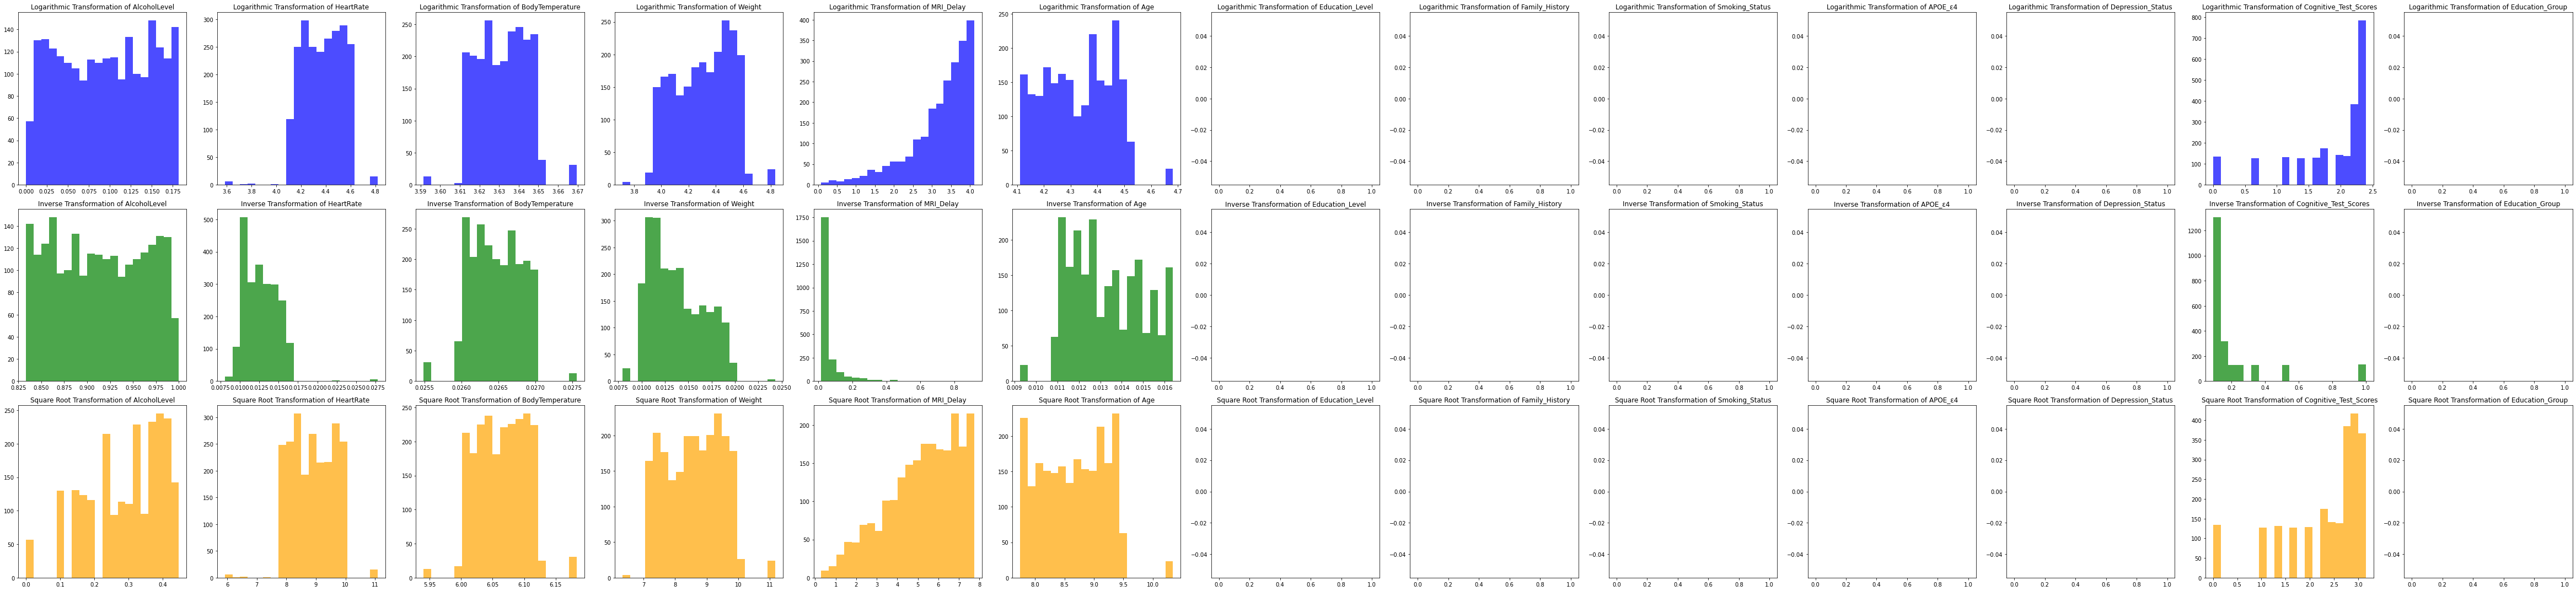

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col
import pyspark.sql.functions as F

# Assume df2 is your DataFrame

# Get all columns in the DataFrame
all_columns = df2.columns

# Perform transformations
transformed_data = df2
for column in all_columns:
    # Logarithmic transformation
    transformed_data = transformed_data.withColumn(f'log_{column}', F.log(col(column) + 1))

    # Inverse transformation
    transformed_data = transformed_data.withColumn(f'inverse_{column}', 1 / (col(column) + 1))

    # Square root transformation
    transformed_data = transformed_data.withColumn(f'sqrt_{column}', F.sqrt(col(column)))

# Plot histograms
num_rows = 3  # Number of transformations
num_cols = len(all_columns)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

for i, column in enumerate(all_columns):
    log_column = f'log_{column}'
    inverse_column = f'inverse_{column}'
    sqrt_column = f'sqrt_{column}'

    # Filter out None values before plotting
    log_data = transformed_data.select(log_column).rdd.flatMap(lambda x: x).collect()
    log_data = [x for x in log_data if x is not None]

    inverse_data = transformed_data.select(inverse_column).rdd.flatMap(lambda x: x).collect()
    inverse_data = [x for x in inverse_data if x is not None]

    sqrt_data = transformed_data.select(sqrt_column).rdd.flatMap(lambda x: x).collect()
    sqrt_data = [x for x in sqrt_data if x is not None]

    # Plot histogram for log transformation
    axs[0, i].hist(log_data, bins=20, color='blue', alpha=0.7)
    axs[0, i].set_title(f'Logarithmic Transformation of {column}')

    # Plot histogram for inverse transformation
    axs[1, i].hist(inverse_data, bins=20, color='green', alpha=0.7)
    axs[1, i].set_title(f'Inverse Transformation of {column}')

    # Plot histogram for square root transformation
    axs[2, i].hist(sqrt_data, bins=20, color='orange', alpha=0.7)
    axs[2, i].set_title(f'Square Root Transformation of {column}')

plt.tight_layout()
plt.show()


In [10]:
# Save DataFrame to a CSV file
#df_filtered_dementia.write.csv("Dataset/df_new_6d.csv", header=True)

In [11]:
# Save DataFrame to a CSV file
#df_filtered_wdementia.write.csv("Dataset/df_new_6wd.csv", header=True)